In [1]:
import numpy as np
import igl
import meshplot as mp
import os
from sklearn.decomposition import PCA
    

from IPython.display import display, HTML, IFrame
mp.jupyter()

In [2]:
# Utility function to generate a tet grid
# n is a 3-tuple with the number of cell in every direction
# mmin/mmax are the grid bounding box corners

def tet_grid(n, mmin, mmax):
    nx = n[0]
    ny = n[1]
    nz = n[2]
    
    delta = mmax-mmin
    
    deltax = delta[0]/(nx-1)
    deltay = delta[1]/(ny-1)
    deltaz = delta[2]/(nz-1)
    
    T = np.zeros(((nx-1)*(ny-1)*(nz-1)*6, 4), dtype=np.int64)
    V = np.zeros((nx*ny*nz, 3))

    mapping = -np.ones((nx, ny, nz), dtype=np.int64)


    index = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                mapping[i, j, k] = index
                V[index, :] = [i*deltax, j*deltay, k*deltaz]
                index += 1
    assert(index == V.shape[0])
    
    tets = np.array([
        [0,1,3,4],
        [5,2,6,7],
        [4,1,5,3],
        [4,3,7,5],
        [3,1,5,2],
        [2,3,7,5]
    ])
    
    index = 0
    for i in range(nx-1):
        for j in range(ny-1):
            for k in range(nz-1):
                indices = [
                    (i,   j,   k),
                    (i+1, j,   k),
                    (i+1, j+1, k),
                    (i,   j+1, k),

                    (i,   j,   k+1),
                    (i+1, j,   k+1),
                    (i+1, j+1, k+1),
                    (i,   j+1, k+1),
                ]
                
                for t in range(tets.shape[0]):
                    tmp = [mapping[indices[ii]] for ii in tets[t, :]]
                    T[index, :]=tmp
                    index += 1
                    
    assert(index == T.shape[0])
    
    V += mmin
    return V, T

# Reading point cloud

In [3]:
def read_mesh_as_point_cloud(filename, shrink_ratio=1):
    p, v = igl.read_triangle_mesh(filename)
    p /= shrink_ratio
    n = igl.per_vertex_normals(p, v)
    return p, n

plot_count = 0
def save_and_display_plot(p):
    global plot_count
    if not os.path.exists("plots"):
        os.makedirs("plots")
    filename = "./plots/"+str(plot_count)+".html"
    p.save(filename)
    display(IFrame(src=filename, width=700, height=600))
    plot_count += 1
    # html = p.to_html(imports=True, html_frame=True)
    # display(HTML(html))
    
pi, ni = read_mesh_as_point_cloud("data/cat.off", 10)
p = mp.plot(pi, shading={"point_size": 8})
save_and_display_plot(p)
print(pi)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, -23.…

Plot saved to file ./plots/0.html.


[[  0.    0.    0. ]
 [ -0.1  -6.    1. ]
 [ -4.4  -3.4  -1. ]
 ...
 [ 26.4 -37.2 -96.2]
 [ 26.2 -44.4 -96.1]
 [ 24.8 -50.2 -96.4]]


# MLS function

In [4]:
# Parameters
bbox_min = np.array([-1., -1., -1.])
bbox_max = np.array([1., 1., 1.])
bbox_diag = np.linalg.norm(bbox_max - bbox_min)

n = 20

In [5]:
# Generate grid n x n x n

x, T = tet_grid((n, n, n), bbox_min - 0.05 * bbox_diag, bbox_max + 0.05 * bbox_diag)

#Compute implicit sphere function
center = np.array([0., 0., 0.])
radius = 1
fx = np.linalg.norm(x-center, axis=1) - radius


In [ ]:
# Treshold fx to visualize inside outside
# print(fx.shape, x.shape)
ind = np.zeros_like(fx)
ind[fx >= 0] = 1
ind[fx < 0] = -1
p = mp.plot(x, c=ind, shading={"point_size": 0.1,"width": 800, "height": 800})
save_and_display_plot(p)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Plot saved to file ./plots/1.html.


In [7]:
# Marching to extract surface

In [8]:
# Marcing tet to extract surface
# print(T)
sv, sf, _, _ = igl.marching_tets(x, T, fx, 0)
p = mp.plot(sv, sf, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

# Setting up the Constraints

In [9]:
# find_closest_point
def find_closest_point(point, points):
    norms = np.linalg.norm(points-point, axis=1)
    closest_point_index = np.argmin(norms)
    # closest_point_index = np.argmin(norms)
    return points[closest_point_index], norms[closest_point_index]

def calc_bounding_box(points):
    largest = np.amax(points, axis=0)
    smallest = np.amin(points, axis=0)
    # print(smallest, largest)
    return smallest, largest

def calc_constraint_for_point(point, normal, eps, norm):
    pi_constraint = [0, 0, 0]
    pi_constraint[0] = point[0]+eps*normal[0]
    pi_constraint[1] = point[1]+eps*normal[1]
    pi_constraint[2] = point[2]+eps*normal[2]
    counter = 0
    # print(np.linalg.norm(pi_constraint-np.array(point)))
    while np.linalg.norm(pi_constraint-np.array(point))>norm:
        counter += 1
        pi_constraint[0] = point[0]+pow(0.5, counter)*eps*normal[0]
        pi_constraint[1] = point[1]+pow(0.5, counter)*eps*normal[1]
        pi_constraint[2] = point[2]+pow(0.5, counter)*eps*normal[2]
    return pi_constraint, pow(0.5, counter)

# Setting up the 

def get_points_constraints(points, normals, find_closest_point_func=None, spatial_indexing=None, eps_ratio=0.01):
    normals = normals/np.linalg.norm(normals, axis=1).reshape(-1, 1)
    # print(np.linalg.norm(normals, axis=0))
    smallest_diagonal, largest_diagonal = calc_bounding_box(pi)
    eps = eps_ratio * np.linalg.norm(np.array(largest_diagonal)-np.array(smallest_diagonal))
    points_list = points.tolist()
    normals_list = normals.tolist()
    points_plus_list = []
    points_minus_list = []
    points_plus_eps_coeff_list = []
    points_minus_eps_coeff_list = []
    for i in range(len(points_list)):
        p = points_list[i]
        n = normals_list[i]
        points_without_p = np.delete(points, [i], axis=0)
        if spatial_indexing==None:
            _, closest_norm = find_closest_point_func(p, points_without_p)
        else:
            _, closest_norm = spatial_indexing.find_closest_point(p, excluded_indices=[i])
        p_plus, p_plus_eps_coeff = calc_constraint_for_point(p, n, eps, closest_norm)
        p_minus, p_minus_eps_coeff = calc_constraint_for_point(p, n, -eps, closest_norm)
        points_plus_list.append(p_plus)
        points_minus_list.append(p_minus)
        points_plus_eps_coeff_list.append(p_plus_eps_coeff)
        points_minus_eps_coeff_list.append(p_minus_eps_coeff)
        
    points_plus = np.array(points_plus_list)
    points_minus = np.array(points_minus_list)
    points_plus_eps_coeff = np.array(points_plus_eps_coeff_list)
    points_minus_eps_coeff = np.array(points_minus_eps_coeff_list)
    points_count = points.shape[0]
    # Constraints
    constraints = np.concatenate((points, points_plus, points_minus))
    # Target Values
    targets = np.zeros(constraints.shape[0])
    targets[:points_count] = 0 # B, Surface
    # print(points_plus_eps_coeff)
    # print(points_minus_eps_coeff)
    targets[points_count:2*points_count] = eps*points_plus_eps_coeff # R, Outside
    targets[2*points_count:] = -eps*points_minus_eps_coeff # G, Inside

    return constraints, targets

def plot_constraints(constraints, targets, point_size=8):
    color = np.zeros(constraints.shape)
    color[targets>0, 0] = 1 # R, Outside
    color[targets<0, 1] = 1 # G, Inside
    color[targets==0, 2] = 1 # B, Surface
    p = mp.plot(constraints, c=color, shading={"point_size": point_size})
    save_and_display_plot(p)
    
c, d = get_points_constraints(pi, ni, find_closest_point)
plot_constraints(c, d)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0120944…

Plot saved to file ./plots/2.html.


# Use MLS interpolation to extend to function `f`

## Create a grid sampling the 3D space

In [10]:
def create_sampling_grid(points, resolution, bbox_increase_ratio=0.05):
    bbox_min, bbox_max = calc_bounding_box(points)
    
    # Enlarge it a bit.
    bbox_diag = np.linalg.norm(bbox_max - bbox_min)
    bbox_min, bbox_max = bbox_min - bbox_increase_ratio * bbox_diag, bbox_max + bbox_increase_ratio * bbox_diag
    
    # Calculate resolution for each axis.
    bbox_size = bbox_max-bbox_min
    largest_size = np.amax(bbox_size)
    unit_size = largest_size/resolution
    grid_size = (np.ceil(bbox_size/unit_size)).astype(int)
    grid_size[grid_size>resolution]=resolution
    bbox_mid = (bbox_max+bbox_min)/2
    bbox_min = bbox_mid-unit_size*grid_size/2
    bbox_max = bbox_mid+unit_size*grid_size/2
    bbox_diag = np.linalg.norm(bbox_max - bbox_min)


    x, T = tet_grid(grid_size, bbox_min, bbox_max)
    return x, T, (grid_size, unit_size, bbox_diag)
    
x, T, info = create_sampling_grid(c, resolution=30)
# Print analytics
print("Final grid size:", info[0], ", Unit size: ", info[1], ", Diagonal size:", info[2])

Final grid size: [18 25 30] , Unit size:  4.063125090291515 , Diagonal size: 174.71437888253516


## Utilities functions

In [ ]:
def calc_3d_polynomial_each_term(v, polyDegree):
    x, y, z = v[0], v[1], v[2]
    result = np.ones((polyDegree+1, polyDegree+1, polyDegree+1))
    # print(result)
    for x_degree in range(1, polyDegree+1):
        result[x_degree:, :, :] *= x
        
    for y_degree in range(1, polyDegree+1):
        result[:, y_degree:, :] *= y
        
    for z_degree in range(1, polyDegree+1):
        result[:, :, z_degree:] *= z
    return result.flatten()

def calc_3d_polynomial_each_term_stacked(v, polyDegree):
    is_stacked = len(v.shape)==2
    if not is_stacked:
        v = v.reshape((1, 3))
    result = np.ones((v.shape[0], polyDegree+1, polyDegree+1, polyDegree+1))
    # print(result)
    for x_degree in range(1, polyDegree+1):
        m = result[:, x_degree:, :, :]
        result[:, x_degree:, :, :] = (m.reshape((v.shape[0], -1))*v[:, 0, np.newaxis]).reshape(m.shape)
        
    for y_degree in range(1, polyDegree+1):
        m = result[:, :, y_degree:, :]
        result[:, :, y_degree:, :] = (m.reshape((v.shape[0], -1))*v[:, 1, np.newaxis]).reshape(m.shape)
        
    for z_degree in range(1, polyDegree+1):
        m = result[:, :, :, z_degree:]
        result[:, :, :, z_degree:] = (m.reshape((v.shape[0], -1))*v[:, 2, np.newaxis]).reshape(m.shape)
    if is_stacked:
        return result.reshape((v.shape[0], -1))
    else:
        return result.flatten()

v = np.array([[1.4, 2.5, 3.6], [4.1, 5.2, 6.3]])

print("calc_3d_polynomial_each_term:")
print(calc_3d_polynomial_each_term(v[0, :], 2))
print(calc_3d_polynomial_each_term(v[1, :], 2))
print("calc_3d_polynomial_each_term (stacked):")
print(calc_3d_polynomial_each_term_stacked(v, 2))
# print(calc_3d_polynomial_each_term_stacked(v[0, :], 2))

calc_3d_polynomial_each_term:
[  1.       3.6     12.96     2.5      9.      32.4      6.25    22.5
  81.       1.4      5.04    18.144    3.5     12.6     45.36     8.75
  31.5    113.4      1.96     7.056   25.4016   4.9     17.64    63.504
  12.25    44.1    158.76  ]
[1.00000000e+00 6.30000000e+00 3.96900000e+01 5.20000000e+00
 3.27600000e+01 2.06388000e+02 2.70400000e+01 1.70352000e+02
 1.07321760e+03 4.10000000e+00 2.58300000e+01 1.62729000e+02
 2.13200000e+01 1.34316000e+02 8.46190800e+02 1.10864000e+02
 6.98443200e+02 4.40019216e+03 1.68100000e+01 1.05903000e+02
 6.67188900e+02 8.74120000e+01 5.50695600e+02 3.46938228e+03
 4.54542400e+02 2.86361712e+03 1.80407879e+04]
calc_3d_polynomial_each_term (stacked):
[[1.00000000e+00 3.60000000e+00 1.29600000e+01 2.50000000e+00
  9.00000000e+00 3.24000000e+01 6.25000000e+00 2.25000000e+01
  8.10000000e+01 1.40000000e+00 5.04000000e+00 1.81440000e+01
  3.50000000e+00 1.26000000e+01 4.53600000e+01 8.75000000e+00
  3.15000000e+01 1.13400000

## MLS Interpolation

In [12]:
class WendlandMLSWithContraints:
    def __init__(self, constraints, targets, poly_func=None, find_neighbors_func=None, spatial_indexing=None):
        self.constraints = constraints
        self.targets = targets
        self.find_neighbors_func = find_neighbors_func
        self.spatial_indexing = spatial_indexing
        self.poly_func = poly_func
        self.LARGE_VALUE = 9999

    def wendland(self, r, h):
        return pow((1-r/h), 4)*((4*r/h)+1)
        
    def interpolate_points_values(self, x, poly_degree, wendland_radius):
        constraints, targets, find_neighbors_func, spatial_indexing, poly_func\
            = self.constraints, self.targets, self.find_neighbors_func, self.spatial_indexing, self.poly_func
        wendland, LARGE_VALUE = self.wendland, self.LARGE_VALUE
        # print(constraints)
        coef_num = pow(polyDegree+1, 3)
        points_within_wendland_radius = np.zeros(x.shape[0], dtype=bool)
        fx = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            xi = x[i, :]
            if spatial_indexing==None:
                neighbors_indices, neighbors_norms = find_neighbors_func(xi, constraints, wendland_radius)
            else:
                neighbors_indices, neighbors_norms = spatial_indexing.find_neighbors(xi, wendland_radius)
                
            if neighbors_indices.shape[0]<2*coef_num:
                points_within_wendland_radius[i] = False
                fx[i] = LARGE_VALUE
            else:
                points_within_wendland_radius[i] = True
                bx = np.zeros((neighbors_indices.shape[0], coef_num))
                # d_target = np.zeros(neighbors_indices.shape[0])
                d_target = targets[neighbors_indices]
                # weight = np.zeros(neighbors_indices.shape[0])
                weight = wendland(neighbors_norms, wendland_radius)
                bx = poly_func(constraints[neighbors_indices], poly_degree)
                
                # for j in range(neighbors_indices.shape[0]):
                    # neighbor_point_index = neighbors_indices[j]
                    # neighbor_point_norm = neighbors_norms[j]
                    # ci = constraints[neighbor_point_index]
                    # weight[j] = wendland(neighbor_point_norm, wendland_radius)
                    # d_target[j] = targets[neighbor_point_index]
                    # Calculate polynomial's terms
                    # bci = poly_func(ci, poly_degree)
                    # bx[j, :] = bci
                    
                # print(i, bx, d_target, weight)
                bx_weighted = bx*np.sqrt(weight[:,np.newaxis])
                d_target_weighted = d_target*np.sqrt(weight)
                
                # bx_weighted = bx
                # d_target_weighted = d_target
                ax, _, _, _ = np.linalg.lstsq(bx_weighted, d_target_weighted, rcond=None)
                fxi = np.dot(poly_func(xi, poly_degree), ax)
                # ax, _, _, _ = np.linalg.lstsq(bx, d_target, rcond=None)
                # fxi = np.dot(poly_func(xi, poly_degree), ax)
                fx[i] = fxi
                # ax2, _, _, _ = np.linalg.lstsq(bx, d_target, rcond=None)
                # fxi2 = np.dot(poly_func(xi, poly_degree), ax2)
                # print(fxi, fxi2, fxi2-fxi)
        return fx, points_within_wendland_radius



# closest_points
def find_closest_points(point, points, h):
    norms = np.linalg.norm(points-point, axis=1)
    closest_points_indices = np.argwhere(norms<h)
    closest_points_indices = closest_points_indices.reshape(closest_points_indices.shape[0])
    return closest_points_indices, norms[closest_points_indices]

def plot_fx(x, fx):
    # Plotting
    ind = np.zeros_like(x)
    ind[fx >= 0, 0] = 1 # Outside, Red
    ind[fx < 0, 1] = 1 # Inside, Green
    # print(ind)
    p = mp.plot(x, c=ind, shading={"point_size": 3,"width": 800, "height": 800})
    save_and_display_plot(p)

wendlandRadius = 30
polyDegree = 2

mlsWithContraints = WendlandMLSWithContraints(c, d, calc_3d_polynomial_each_term_stacked, find_closest_points)
fx, in_wend = mlsWithContraints.interpolate_points_values(x, polyDegree, wendlandRadius)

# Plotting
print("Fx gird:")
plot_fx(x, fx)

# Marcing tet to extract surface
print("Marcing Tets:")
sv, sf, _, _ = igl.marching_tets(x, T, fx, 0)
p = mp.plot(sv, sf, shading={"wireframe": True})
save_and_display_plot(p)

# print("Marcing Filtered:")
# p = mp.plot(sv, get_main_component(sf), shading={"wireframe": True})

# Debug plotting
print("Debug Plottings:")
ind = np.zeros_like(x)
ind[(in_wend==True) & (fx > 0), 0] = 1 # In wendlandRadius, counted outnside, Red
ind[(in_wend==True) & (fx <= 0), 1] = 1 # In wendlandRadius, counted inside, Green
ind[(in_wend==False) & (fx <= 0), 2] = 1 # Outside wendlandRadius, but counted inside, Blue
p = mp.plot(x, c=ind, shading={"point_size": 3,"width": 800, "height": 800})

fx_in_wend = np.zeros(x.shape[0])
fx_in_wend[in_wend] = -1
fx_in_wend[in_wend==False] = 1
# Marcing tet to extract surface
sv, sf, _, _ = igl.marching_tets(x, T, fx_in_wend, 0)
p = mp.plot(sv, sf, shading={"wireframe": True})


Fx gird:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0120944…

Plot saved to file ./plots/3.html.


Marcing Tets:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0120944…

Plot saved to file ./plots/4.html.


Debug Plottings:


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0120944…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0120944…

















































































































# Implementing a spatial index to accelerate neighbor calculations

In [13]:
def save_spatial_index(points, saved_spatial_indices, bbox_min, unit_box_size, filename):
    with open(filename, 'w') as f:
        # Save grid size
        grid_shape = saved_spatial_indices.shape
        f.write(f"{grid_shape[0]} {grid_shape[1]} {grid_shape[2]}\n")
        # Save bbox_min
        f.write(f"{bbox_min[0]} {bbox_min[1]} {bbox_min[2]}\n")
        # Save unit_box_size (assume cubic grid, so just one value)
        f.write(f"{unit_box_size}\n")
        # Save number of points
        f.write(f"{points.shape[0]}\n")
        # Save all points
        for pt in points:
            f.write(f"{pt[0]} {pt[1]} {pt[2]}\n")
        # Save the grid: for each cell, write the indices (space-separated)
        for x in range(grid_shape[0]):
            for y in range(grid_shape[1]):
                for z in range(grid_shape[2]):
                    indices = saved_spatial_indices[x, y, z]
                    f.write(" ".join(map(str, indices)) + "\n")

class SpatialIndexing:
    def __init__(self, points, resolution):
        bbox_min, bbox_max = calc_bounding_box(points)
        # print(bbox_min, bbox_max)
        # Calculate resolution for each axis.
        bbox_size = bbox_max-bbox_min
        largest_size = np.amax(bbox_size)
        unit_size = largest_size/resolution
        grid_size = (np.ceil(bbox_size/unit_size)).astype(int)

        self.grid_size = grid_size
        self.bbox_min = bbox_min
        self.bbox_max = bbox_max
        self.box_size = bbox_max-bbox_min
        self.unit_box_size = self.box_size/grid_size
        
        # print(grid_size, self.saved_spatial_indices.shape)
        # self.saved_spatial_indices = [[] for i in range(grid_size[0]*grid_size[1]*grid_size[2])]
        self._save_points(points)
        
    def calc_spatial_index_3d(self, p):
        x_size, y_size, z_size = self.grid_size
        p_in_box = p-self.bbox_min
        index = np.minimum(np.floor(p_in_box/self.unit_box_size), self.grid_size-1)
        if index[0]>=x_size:
            index[0]=x_size-1
        if index[1]>=y_size:
            index[1]=y_size-1
        if index[2]>=z_size:
            index[2]=z_size-1
        # print(self.grid_size, index)
        return index.astype(int)
    

    def _save_points(self, points):
        self.points = points
        grid_size = self.grid_size
        saved_spatial_indices_list = [[[[] for i in range(grid_size[2])] for i in range(grid_size[1])] for i in range(grid_size[0])]
        for i in range(points.shape[0]):
            p = points[i, :]
            spatial_index = self.calc_spatial_index_3d(p)
            saved_spatial_indices_list[spatial_index[0]][spatial_index[1]][spatial_index[2]].append(i)
        self.saved_spatial_indices = np.array(saved_spatial_indices_list, dtype=list)
        save_spatial_index(points, self.saved_spatial_indices, self.bbox_min, self.unit_box_size[0], "spatial_index.txt")
        # print(self.saved_spatial_indices.shape)
        
    def get_box_neighbors_indices(self, p, r):
        p_bbox_min = np.maximum(p-r, self.bbox_min)
        p_bbox_max = np.minimum(p+r, self.bbox_max)
        p_bbox_min_s_index = self.calc_spatial_index_3d(p_bbox_min)
        p_bbox_max_s_index = self.calc_spatial_index_3d(p_bbox_max)
 
        points_array = self.saved_spatial_indices[p_bbox_min_s_index[0]:p_bbox_max_s_index[0]+1, p_bbox_min_s_index[1]:p_bbox_max_s_index[1]+1, p_bbox_min_s_index[2]:p_bbox_max_s_index[2]+1]

        result = []
        for l in points_array.flatten():
            result+=l
        return np.array(result, dtype=int)

    # Don't like the name, but alias it to find_neighbors
    def find_closest_points(self, point, h):
        return self.find_neighbors(point, h)
        
    def find_neighbors(self, point, h):
        box_neighbors_indices = self.get_box_neighbors_indices(point, h)
        points = self.points[box_neighbors_indices, :]
        norms = np.linalg.norm(points-point, axis=1)
        neighbors_points_indices = np.argwhere(norms<h)
        neighbors_points_indices = neighbors_points_indices.reshape(neighbors_points_indices.shape[0])
        
        return box_neighbors_indices[neighbors_points_indices], norms[neighbors_points_indices]
        
    def find_closest_point_helper(self, point, excluded_indices, radius_level=0, reached_bottom=False):
        point_3d_index = self.calc_spatial_index_3d(point)
        point_bbox_min = np.maximum(point_3d_index-radius_level, 0)
        point_bbox_max = np.minimum(point_3d_index+radius_level, np.array(self.grid_size)-1)
        
        closest_norm = None
        closest_point = None

        
        # Loop over the range of x, y, z
        for x in range(point_bbox_min[0], point_bbox_max[0] + 1):
            for y in range(point_bbox_min[1], point_bbox_max[1] + 1):
                for z in range(point_bbox_min[2], point_bbox_max[2] + 1):
                     # Check if the current cell is on the surface
                    if (x == point_bbox_min[0] or x == point_bbox_max[0] or
                        y == point_bbox_min[1] or y == point_bbox_max[1] or
                        z == point_bbox_min[2] or z == point_bbox_max[2]):
                        points_indices = [x for x in self.saved_spatial_indices[x, y, z] if x not in excluded_indices]
                        points = self.points[points_indices, :]
                        if len(points)>0:
                            norms = np.linalg.norm(points-point, axis=1)
                            closest_point_index = np.argmin(norms)
                            closest_point_norm = norms[closest_point_index]
                            if closest_norm==None or closest_point_norm<closest_norm:
                                closest_norm = closest_point_norm
                                closest_point = points[closest_point_index]
        
        if closest_norm==None:
            return self.find_closest_point_helper(point, excluded_indices, radius_level+1)
        elif reached_bottom:
            return closest_point, closest_norm
        else:
            next_step_value = self.find_closest_point_helper(point, excluded_indices, radius_level+1, True)
            # There is a possibility that the closest point lied in next step, if the point close to boundary in its cell.
            if next_step_value[1]<closest_norm:
                return next_step_value[0], next_step_value[1]
            else:
                return closest_point, closest_norm
        
    def find_closest_point(self, point, excluded_indices=[]):
        return self.find_closest_point_helper(point, excluded_indices)
        
spatialIndexing = SpatialIndexing(c, 10)



# SML/MaPLe Bindings

In [14]:
import subprocess

# Run the executable file of `make closest-points`.
def find_closest_point_sml(p, points, sml_exec_path='./closest-point'):
    # Prepare the input string (query point + all points)
    input_str = ' '.join(map(str, p)) + '\n'
    for pt in points:
        input_str += ' '.join(map(str, pt)) + '\n'

    h = 1e10
    result = subprocess.run(
        [sml_exec_path, str(h)],
        input=input_str,
        stdout=subprocess.PIPE,
        text=True
    )
    lines = result.stdout.strip().split('\n')
    if len(lines) < 2 or not lines[0].strip():
        raise ValueError("No points found by SML")
    indices = list(map(int, lines[0].split()))
    norms = list(map(float, lines[1].split()))
    min_idx = np.argmin(norms)
    closest_index = indices[min_idx]
    closest_distance = norms[min_idx]
    closest_point = points[closest_index]
    return closest_point, closest_distance

def find_closest_point_sml_parallel(p, points, sml_exec_path='./closest-point-parallel', procs=4):
    # Prepare the input string (query point + all points)
    input_str = ' '.join(map(str, p)) + '\n'
    for pt in points:
        input_str += ' '.join(map(str, pt)) + '\n'

    h = 1e10
    result = subprocess.run(
        [sml_exec_path, '@mpl', 'procs', str(procs), '--', str(h)],
        input=input_str,
        stdout=subprocess.PIPE,
        text=True
    )
    lines = result.stdout.strip().split('\n')
    if len(lines) < 2 or not lines[0].strip():
        raise ValueError("No points found by SML (parallel)")
    indices = list(map(int, lines[0].split()))
    norms = list(map(float, lines[1].split()))
    min_idx = np.argmin(norms)
    closest_index = indices[min_idx]
    closest_distance = norms[min_idx]
    closest_point = points[closest_index]
    return closest_point, closest_distance


def find_closest_point_spatial_sml(query_point, sml_exec_path='./closest-point-spatial'):
    """
    query_point: a numpy array or list of 3 floats
    sml_exec_path: path to the compiled SML executable
    Returns: (closest_point as np.array)
    """
    # Prepare the input string (query point as "x y z\n")
    input_str = ' '.join(map(str, query_point)) + '\n'
    # Call the SML executable
    result = subprocess.run(
        [sml_exec_path],
        input=input_str,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    if result.returncode != 0:
        raise RuntimeError(f"SML error: {result.stderr}")
    # Parse the output
    output = result.stdout.strip()
    if not output:
        raise ValueError("No output from SML spatial index")
    coords = list(map(float, output.split()))
    if len(coords) != 3:
        raise ValueError(f"Unexpected output: {output}")
    return np.array(coords)


def find_closest_point_spatial_sml_parallel(query_point, sml_exec_path='./closest-point-spatial-parallel', procs=4):
    """
    query_point: a numpy array or list of 3 floats
    sml_exec_path: path to the compiled SML executable
    Returns: (closest_point as np.array)
    """
    # Prepare the input string (query point as "x y z\n")
    input_str = ' '.join(map(str, query_point)) + '\n'
    # Call the SML executable
    result = subprocess.run(
        [sml_exec_path, '@mpl', 'procs', str(procs) , '--'],
        input=input_str,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    if result.returncode != 0:
        raise RuntimeError(f"SML error: {result.stderr}")
    # Parse the output
    output = result.stdout.strip()
    if not output:
        raise ValueError("No output from SML spatial index")
    coords = list(map(float, output.split()))
    if len(coords) != 3:
        raise ValueError(f"Unexpected output: {output}")
    return np.array(coords)


# Testing Closest Points

In [15]:
# Testing start by defining a point
pi, ni = read_mesh_as_point_cloud("data/car.obj", 10)
print(str(pi.shape))

(152837, 3)


  o Plane.013
  o Circle.038
  o Circle.037
  o Circle.034
  o Circle.031
  o Circle.016
  o Cube.003
  o Circle.025
  o Circle.006
  o Circle.012
  o Circle.003
  o Circle.002
  o Circle.000
  o Cylinder.000
  o Circle.018
  o Circle.061
  o Cube.010
  o Cube.009
  o Cube.007
  o Circle.041
  o Cylinder.006
  o Circle.060
  o Circle.056
  o Cube.004
  o Cylinder.009
  o Plane.011
  o Plane.010
  o Cube
  o Cylinder.003
  o Plane.007
  o Plane.002
  o Plane.001
  o Cylinder.002
  o Plane.003
  o Circle.040
  o Plane.009
  o Plane.004
  o Circle.051
  o Circle.024
  o Plane
  o Circle.036
  o Circle.035
  o Circle.033
  o Circle.030
  o Circle.027
  o Circle.026
  o Circle.020
  o Circle.010
  o Circle.009
  o Circle.001
  o Cube.006
  o Circle.050
  o Circle.048
  o Plane.005
  o Circle.007
  o Circle.017
  o Circle.004
  o Circle.005
  o Circle.008
  o Circle.011
  o Circle.013
  o Circle.014
  o Plane.015


In [16]:
# c, d = get_points_constraints(pi, ni, find_closest_point_sml_parallel, None, 0.01)
p = np.array([-11.18728482, -25.91066198, -5.58257382])

print('Results in different implementations of point:(', *p, ')')
print('"find_closest_points":')
cps, n = find_closest_points(p, c, 13)
cps2, n2 = spatialIndexing.find_closest_points(p, 13)
print(n.shape, n2.shape)
print(cps[:3], cps2[:3])
print(n[:3], n2[:3])
# print(n, n2)
import time

print('"find_closest_point":')
# print(str(c.shape))

# Python implementation
# start = time.time()
# cp = find_closest_point(p, pi)
# end = time.time()
# print("Python:", cp, "Time:", end - start, "seconds")

si = SpatialIndexing(pi, 20)
# Spatial Indexing implementation
# start = time.time()
# si.find_closest_point(p)
# end = time.time()
# print("Spatial:", cp, "Time:", end - start, "seconds")

# SML implementation
start = time.time()
cp3 = find_closest_point_sml(p, pi)
end = time.time()
print("SML:", cp3, "Time:", end - start, "seconds")

# SML Parallel implementation
start = time.time()
cp4 = find_closest_point_sml_parallel(p, pi, procs=4)
end = time.time()
print("SML Parallel:", cp4, "Time:", end - start, "seconds")

# SML Spatial Indexing implementation
start = time.time()
cp5 = find_closest_point_spatial_sml(p)
end = time.time()
print("SML Spatial Indexing:", cp5, "Time:", end - start, "seconds")

# SML Spatial Indexing Parallel implementation
start = time.time()
cp6 = find_closest_point_spatial_sml_parallel(p, procs=4)
end = time.time()
print("SML Spatial Indexing Parallel:", cp6, "Time:", end - start, "seconds")



Results in different implementations of point:( -11.18728482 -25.91066198 -5.58257382 )
"find_closest_points":
(3,) (3,)
[ 23 389 390] [390  23 389]
[12.80069945 11.38976057 12.07831045] [12.07831045 12.80069945 11.38976057]
"find_closest_point":
SML: (array([-0.1917981,  0.0144932, -0.3559509]), 28.6414382751) Time: 6.225057601928711 seconds
SML Parallel: (array([-0.1917981,  0.0144932, -0.3559509]), 28.6414382751) Time: 8.724385023117065 seconds
SML Spatial Indexing: [-0.1917981  0.0144932 -0.3559509] Time: 1.907541275024414 seconds
SML Spatial Indexing Parallel: [-0.1917981  0.0144932 -0.3559509] Time: 2.3712167739868164 seconds


# Benchmark

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import re

def plot_closest_point_spatial_sml_parallel_benchmark(num_queries=5000, num_repeat=4, procs=16, sml_exec_path='./closest-point-spatial-parallel-bench'):
    # Build the command
    cmd = [
        sml_exec_path,
        '@mpl', 'procs', str(procs), '--',
        'queries', str(num_queries),
        'repeat', str(num_repeat),
        'procs', str(procs)
    ]
    # Run the command
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode != 0:
        print("Error running SML benchmark:", result.stderr)
        return []
    # Parse the output
    output = result.stdout
    pattern = r"Cores: (\d+) Avg: ([\d\.]+)s"
    matches = re.findall(pattern, output)
    results = []
    for core, avg in matches:
        # print(f"Cores: {core} Avg: {avg}s")
        results.append((int(core), float(avg)))
    return results

# Plot the results speed up wrt to only 1 core
def plot_results(results):
    cores, times = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(cores, times, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Cores')
    plt.ylabel('Average Time (seconds)')
    plt.title('Closest Point Spatial SML Parallel Benchmark')
    plt.show()

Cores: 1 Avg: 2.4410s
Cores: 2 Avg: 3.1088s
Cores: 3 Avg: 3.1769s
Cores: 4 Avg: 3.1306s
Cores: 5 Avg: 1.4771s
Cores: 6 Avg: 1.0843s
Cores: 7 Avg: 1.3308s
Cores: 8 Avg: 1.0794s
Cores: 9 Avg: 0.9172s
Cores: 10 Avg: 0.6415s
Cores: 11 Avg: 0.5870s
Cores: 12 Avg: 0.5165s
Cores: 13 Avg: 0.6050s
Cores: 14 Avg: 0.6206s
Cores: 15 Avg: 0.5578s
Cores: 16 Avg: 0.5417s


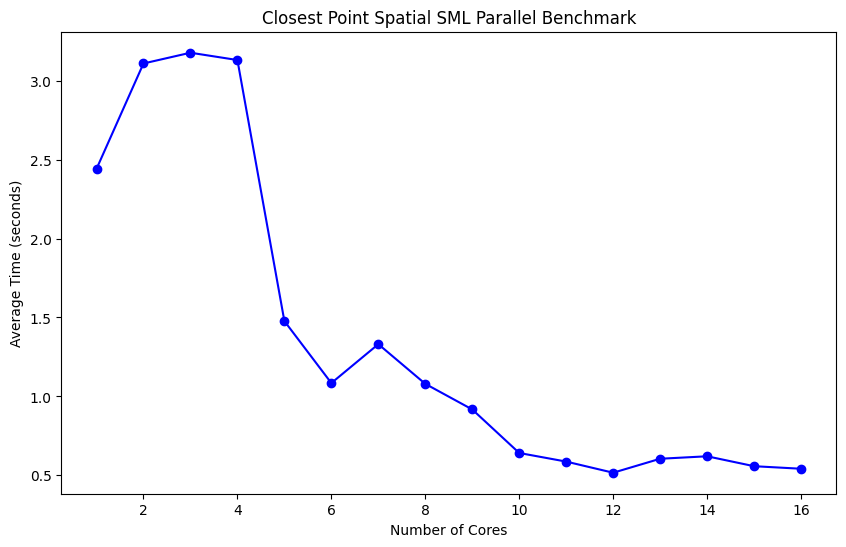

In [20]:
results = plot_closest_point_spatial_sml_parallel_benchmark()
plot_results(results)